In [13]:
from PIL import Image
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras_preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import preprocess_input
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense

In [ ]:
path = '/content/drive/MyDrive/DM-project/'
path += 'Grapevine_Leaves_Image_Dataset/'
types = [e for e in os.walk(path)][0][1]
df = {}
for i in range(1,6):
    leave_name = [e for e in os.walk(path)][0][1][i-1]
    paths=[f'{path}{name.split()[0]}/{name}' for name in [e for e in os.walk(path)][i][2]]
    df[leave_name] = paths
df = pd.DataFrame(df)
df.head()

,Dimnit,Nazli,Ak,Buzgulu,Ala_Idris
0,/content/drive/MyDrive/DM-project/Grapevine_Le...,/content/drive/MyDrive/DM-project/Grapevine_Le...,/content/drive/MyDrive/DM-project/Grapevine_Le...,/content/drive/MyDrive/DM-project/Grapevine_Le...,/content/drive/MyDrive/DM-project/Grapevine_Le...
1,/content/drive/MyDrive/DM-project/Grapevine_Le...,/content/drive/MyDrive/DM-project/Grapevine_Le...,/content/drive/MyDrive/DM-project/Grapevine_Le...,/content/drive/MyDrive/DM-project/Grapevine_Le...,/content/drive/MyDrive/DM-project/Grapevine_Le...
2,/content/drive/MyDrive/DM-project/Grapevine_Le...,/content/drive/MyDrive/DM-project/Grapevine_Le...,/content/drive/MyDrive/DM-project/Grapevine_Le...,/content/drive/MyDrive/DM-project/Grapevine_Le...,/content/drive/MyDrive/DM-project/Grapevine_Le...
3,/content/drive/MyDrive/DM-project/Grapevine_Le...,/content/drive/MyDrive/DM-project/Grapevine_Le...,/content/drive/MyDrive/DM-project/Grapevine_Le...,/content/drive/MyDrive/DM-project/Grapevine_Le...,/content/drive/MyDrive/DM-project/Grapevine_Le...
4,/content/drive/MyDrive/DM-project/Grapevine_Le...,/content/drive/MyDrive/DM-project/Grapevine_Le...,/content/drive/MyDrive/DM-project/Grapevine_Le...,/content/drive/MyDrive/DM-project/Grapevine_Le...,/content/drive/MyDrive/DM-project/Grapevine_Le...


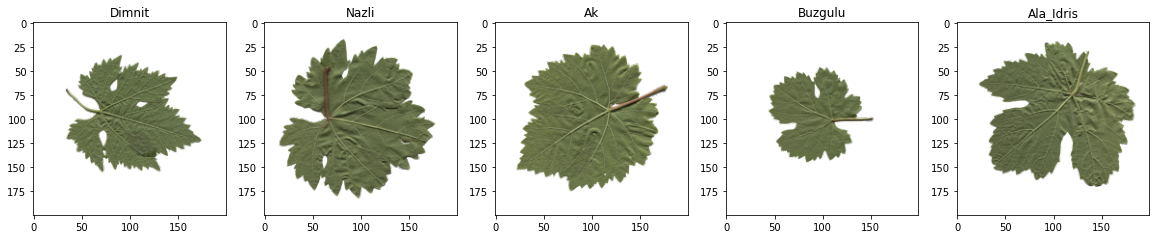

In [ ]:
plt.figure(figsize = (20,12))
for id,name in enumerate(df.columns):
    plt.subplot(1,5,id+1)
    plt.title(name)
    img_path = df.loc[2,name]
    plt.imshow(Image.open(img_path).resize((200,200)))
plt.show()

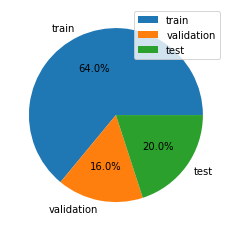

In [ ]:
dfxy = pd.DataFrame({'path':pd.concat([df.Ak,df.Ala_Idris,df.Buzgulu,df.Dimnit,df.Nazli]),
                     'label':np.repeat(['Ak','Ala_Idris','Buzgulu','Dimnit','Nazli'],100)})
x_train, x_test, y_train, y_test = train_test_split(dfxy.path, dfxy.label, test_size=0.2, random_state=50)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=32)
plt.pie([len(x_train),len(x_valid),len(x_test)], labels=['train','validation','test'], autopct='%1.1f%%')
plt.legend(loc='upper right')
plt.show()

In [ ]:
train_val_data_gen = ImageDataGenerator(
    rotation_range=45,
    zoom_range=0.1,
    brightness_range=[0.5,1.5],
    channel_shift_range=0.5,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2,
    fill_mode='constant',
    cval=0.0,
    #preprocessing_function= preprocess_input,  
) 
test_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
inputs = {'x_col':'path','y_col':'label','target_size':(227, 227),'batch_size':32,'class_mode':"categorical"}
train= train_val_data_gen.flow_from_dataframe(pd.concat([x_train,y_train],axis=1),**inputs)
valid= train_val_data_gen.flow_from_dataframe(pd.concat([x_valid,y_valid],axis=1),**inputs)
test = test_data_gen.flow_from_dataframe(pd.concat([x_test,y_test],axis=1), **inputs)

Found 320 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.


In [ ]:
# function below takes a data generator and plots some random images
# followed by them being augmented!
def showAugmentedData(paths, datagen):
    plt.figure(figsize = (15,10))
    plt.suptitle('Augmented Images')
    id = 0
    for path in paths:
        orgImg = Image.open(path).resize((200,200))
        it = datagen.flow(np.expand_dims(orgImg, 0), batch_size=1)
    
        # Original Image
        plt.subplot(5,5, id+1)
        plt.imshow(orgImg)
    
        # Augmented Images
        for _ in range(4):
            id += 1
            plt.subplot(5,5, id+1)
            plt.imshow(it.next()[0].astype('uint8'))
        id += 1
    
    plt.tight_layout()
    plt.show()

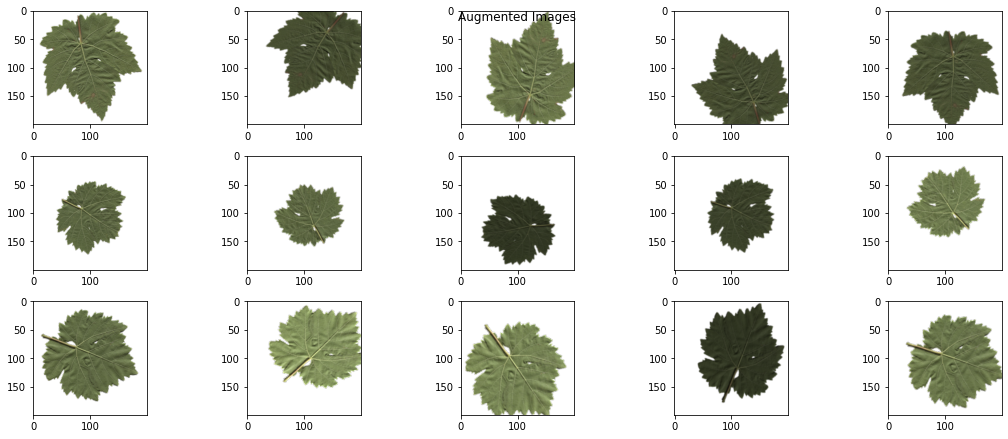

In [ ]:
showAugmentedData(np.random.choice(x_train,3), train_val_data_gen)

In [16]:
col_count = 227*227
input_dim = Input(shape = (col_count, ))

# Encoder Layers
encoded1 = Dense(3000, activation = 'relu')(input_dim)
encoded2 = Dense(2750, activation = 'relu')(encoded1)
encoded3 = Dense(2500, activation = 'relu')(encoded2)
encoded4 = Dense(2250, activation = 'relu')(encoded3)
encoded5 = Dense(2000, activation = 'relu')(encoded4)
encoded6 = Dense(1750, activation = 'relu')(encoded5)
encoded7 = Dense(1500, activation = 'relu')(encoded6)
encoded8 = Dense(1250, activation = 'relu')(encoded7)
encoded9 = Dense(1000, activation = 'relu')(encoded8)
encoded10 = Dense(750, activation = 'relu')(encoded9)
encoded11 = Dense(500, activation = 'relu')(encoded10)
encoded12 = Dense(250, activation = 'relu')(encoded11)
encoded13 = Dense(200, activation = 'relu')(encoded12)

# Decoder Layers
decoded1 = Dense(250, activation = 'relu')(encoded13)
decoded2 = Dense(500, activation = 'relu')(decoded1)
decoded3 = Dense(750, activation = 'relu')(decoded2)
decoded4 = Dense(1000, activation = 'relu')(decoded3)
decoded5 = Dense(1250, activation = 'relu')(decoded4)
decoded6 = Dense(1500, activation = 'relu')(decoded5)
decoded7 = Dense(1750, activation = 'relu')(decoded6)
decoded8 = Dense(2000, activation = 'relu')(decoded7)
decoded9 = Dense(2250, activation = 'relu')(decoded8)
decoded10 = Dense(2500, activation = 'relu')(decoded9)
decoded11 = Dense(2750, activation = 'relu')(decoded10)
decoded12 = Dense(3000, activation = 'relu')(decoded11)
decoded13 = Dense(col_count, activation = 'sigmoid')(decoded12)

autoencoder = Model(inputs = input_dim, outputs = decoded13)
autoencoder.compile(optimizer = 'adadelta', loss = 'binary_crossentropy')
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 51529)]           0         
                                                                 
 dense (Dense)               (None, 3000)              154590000 
                                                                 
 dense_1 (Dense)             (None, 2750)              8252750   
                                                                 
 dense_2 (Dense)             (None, 2500)              6877500   
                                                                 
 dense_3 (Dense)             (None, 2250)              5627250   
                                                                 
 dense_4 (Dense)             (None, 2000)              4502000   
                                                                 
 dense_5 (Dense)             (None, 1750)              350175

In [ ]:
autoencoder.fit(X_train, X_train, nb_epoch = 10, batch_size = 32, shuffle = False, validation_data = (X_test, X_test))
encoder = Model(inputs = input_dim, outputs = encoded13)
encoded_input = Input(shape = (encoding_dim, ))

#encoded dimention reductioned data
encoded_train = pd.DataFrame(encoder.predict(train))
encoded_test = pd.DataFrame(encoder.predict(test))


### know we can start training diffrent pre trained model with our data!

In [ ]:
from keras.applications.vgg19 import VGG19
import tensorflow as tf
callbacks = [tf.keras.callbacks.ModelCheckpoint("save_model_xception.h5", save_best_only=True)]
vgg19 = tf.keras.applications.VGG19(include_top = False, input_shape = (227,227,3), weights = 'imagenet')

for layer in vgg19.layers: layer.trainable = False

x = GlobalAveragePooling2D()(vgg19.output)
predictions = Dense(5, activation='softmax')(x)

model_vgg = Model(inputs = vgg19.input, outputs = predictions)
model_vgg.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [ ]:
history_vgg = model_vgg.fit(train,validation_data=valid,epochs=2,verbose=2,callbacks = callbacks)

Epoch 1/2
10/10 - 283s - loss: 2.9064 - accuracy: 0.1813 - val_loss: 2.3748 - val_accuracy: 0.1500 - 283s/epoch - 28s/step
Epoch 2/2
10/10 - 258s - loss: 2.0562 - accuracy: 0.2438 - val_loss: 2.1388 - val_accuracy: 0.1875 - 258s/epoch - 26s/step


In [ ]:
#with GPU
history_vgg = model_vgg.fit(train,validation_data=valid,epochs=2,verbose=2,callbacks = callbacks)

Epoch 1/2
10/10 - 62s - loss: 7.6398 - accuracy: 0.1875 - val_loss: 3.7434 - val_accuracy: 0.3250 - 62s/epoch - 6s/step
Epoch 2/2
10/10 - 8s - loss: 3.4785 - accuracy: 0.2438 - val_loss: 3.6710 - val_accuracy: 0.2375 - 8s/epoch - 829ms/step


In [ ]:
history_vgg = model_vgg.fit(
      train,
      validation_data=valid,
      epochs=40,
      verbose=1,
      callbacks = callbacks)

Epoch 1/40
10/10 [==============================] - 59s 842ms/step - loss: 0.6818 - accuracy: 0.7719 - val_loss: 0.8126 - val_accuracy: 0.7000
Epoch 2/40
10/10 [==============================] - 8s 831ms/step - loss: 0.6223 - accuracy: 0.7563 - val_loss: 0.8745 - val_accuracy: 0.6500
Epoch 3/40
10/10 [==============================] - 8s 826ms/step - loss: 0.6044 - accuracy: 0.7844 - val_loss: 0.7105 - val_accuracy: 0.7375
Epoch 4/40
10/10 [==============================] - 8s 854ms/step - loss: 0.5954 - accuracy: 0.8062 - val_loss: 0.6842 - val_accuracy: 0.7125
Epoch 5/40
10/10 [==============================] - 8s 848ms/step - loss: 0.5962 - accuracy: 0.7875 - val_loss: 0.6493 - val_accuracy: 0.7625
Epoch 6/40
10/10 [==============================] - 8s 827ms/step - loss: 0.5456 - accuracy: 0.8031 - val_loss: 0.7901 - val_accuracy: 0.7375
Epoch 7/40
10/10 [==============================] - 8s 850ms/step - loss: 0.5940 - accuracy: 0.7875 - val_loss: 0.6279 - val_accuracy: 0.7875
Epoch

In [ ]:
pred = model_vgg.evaluate(test)

4/4 [==============================] - 10s 3s/step - loss: 1.0922 - accuracy: 0.6900


In [ ]:
resnet50 = tf.keras.applications.ResNet50(include_top = False, input_shape = (227,227,3), weights = 'imagenet')

for layer in resnet50.layers:layer.trainable = False

x = GlobalAveragePooling2D()(resnet50.output)
predictions = Dense(5, activation='softmax')(x)

model_resnet50 = Model(inputs = resnet50.input, outputs = predictions)
model_resnet50.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])



94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
history_resnet50 = model_resnet50.fit(
      train,
      validation_data=valid,
      epochs=50,
      verbose=1,
      callbacks = callbacks)

Epoch 1/50
10/10 [==============================] - 12s 949ms/step - loss: 1.8515 - accuracy: 0.1656 - val_loss: 1.5491 - val_accuracy: 0.3250
Epoch 2/50
10/10 [==============================] - 8s 784ms/step - loss: 1.5506 - accuracy: 0.3063 - val_loss: 1.4116 - val_accuracy: 0.4750
Epoch 3/50
10/10 [==============================] - 8s 782ms/step - loss: 1.3935 - accuracy: 0.3938 - val_loss: 1.3345 - val_accuracy: 0.4750
Epoch 4/50
10/10 [==============================] - 8s 794ms/step - loss: 1.3859 - accuracy: 0.4187 - val_loss: 1.3109 - val_accuracy: 0.4125
Epoch 5/50
10/10 [==============================] - 8s 785ms/step - loss: 1.2720 - accuracy: 0.5094 - val_loss: 1.1801 - val_accuracy: 0.5250
Epoch 6/50
10/10 [==============================] - 8s 789ms/step - loss: 1.1881 - accuracy: 0.5188 - val_loss: 1.1696 - val_accuracy: 0.5625
Epoch 7/50
10/10 [==============================] - 8s 790ms/step - loss: 1.1441 - accuracy: 0.5594 - val_loss: 1.1953 - val_accuracy: 0.5250
Epoch

In [ ]:
pred = model_resnet50.evaluate(test)

4/4 [==============================] - 1s 329ms/step - loss: 0.8689 - accuracy: 0.6900


In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint("save_model_xception.h5", save_best_only=True)]
ENB3 = tf.keras.applications.EfficientNetB3(include_top = False, input_shape = (227,227,3), weights = 'imagenet')

for layer in ENB3.layers:layer.trainable = False

x = GlobalAveragePooling2D()(ENB3.output)
predictions = Dense(5, activation='softmax')(x)

model_ENB3 = Model(inputs = ENB3.input, outputs = predictions)
model_ENB3.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [ ]:
history_ENB3 = model_ENB3.fit(
      train,
      validation_data=valid,
      epochs=40,
      verbose=1,
      callbacks = callbacks)

Epoch 1/40
10/10 [==============================] - 21s 1s/step - loss: 1.6229 - accuracy: 0.2344 - val_loss: 1.4741 - val_accuracy: 0.4250
Epoch 2/40
10/10 [==============================] - 8s 867ms/step - loss: 1.4792 - accuracy: 0.3938 - val_loss: 1.3904 - val_accuracy: 0.4500
Epoch 3/40
10/10 [==============================] - 9s 869ms/step - loss: 1.3451 - accuracy: 0.4938 - val_loss: 1.2663 - val_accuracy: 0.5500
Epoch 4/40
10/10 [==============================] - 9s 910ms/step - loss: 1.2526 - accuracy: 0.5406 - val_loss: 1.2186 - val_accuracy: 0.5875
Epoch 5/40
10/10 [==============================] - 9s 966ms/step - loss: 1.1895 - accuracy: 0.5969 - val_loss: 1.1557 - val_accuracy: 0.6000
Epoch 6/40
10/10 [==============================] - 9s 871ms/step - loss: 1.1530 - accuracy: 0.5719 - val_loss: 1.1051 - val_accuracy: 0.6625
Epoch 7/40
10/10 [==============================] - 9s 866ms/step - loss: 1.1189 - accuracy: 0.5938 - val_loss: 1.0203 - val_accuracy: 0.7125
Epoch 8/

In [ ]:
pred = model_ENB3.evaluate(test)

4/4 [==============================] - 2s 365ms/step - loss: 0.7959 - accuracy: 0.7600


So we can't reach better result! let's see if we can build datas better

In [ ]:
train_val_data_gen = ImageDataGenerator(
    rotation_range=45,
    zoom_range=0.1,
    brightness_range=[0.5,1.5],
    channel_shift_range=0.5,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2,
    fill_mode='constant',
    cval=0.0,
    preprocessing_function= preprocess_input,  
) 
test_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

Found 320 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.


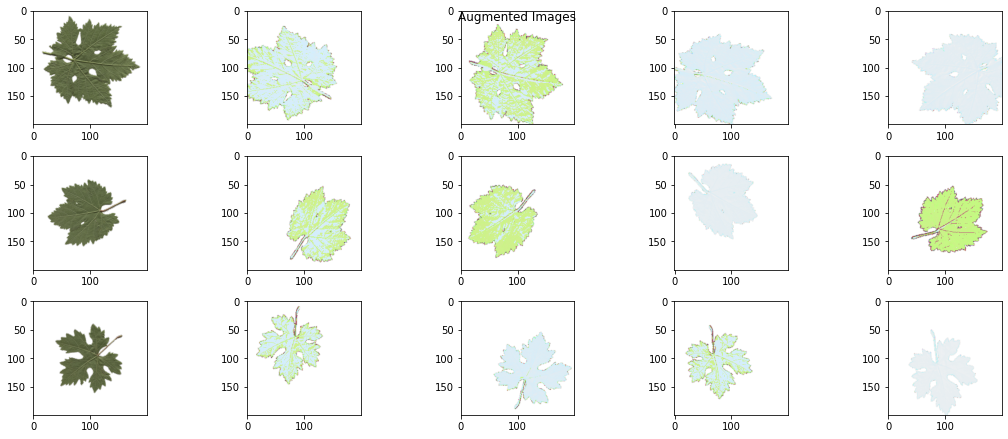

In [ ]:
inputs = {'x_col':'path','y_col':'label','target_size':(227, 227),'batch_size':32,'class_mode':"categorical",'shuffle':False}
train= train_val_data_gen.flow_from_dataframe(pd.concat([x_train,y_train],axis=1),**inputs)
valid= train_val_data_gen.flow_from_dataframe(pd.concat([x_valid,y_valid],axis=1),**inputs)
test = test_data_gen.flow_from_dataframe(pd.concat([x_test,y_test],axis=1), **inputs)
showAugmentedData(np.random.choice(x_train,3), train_val_data_gen)

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint("save_model_xception.h5", save_best_only=True)]
ENB3 = tf.keras.applications.EfficientNetB3(include_top = False, input_shape = (227,227,3), weights = 'imagenet')

for layer in ENB3.layers:layer.trainable = False

x = GlobalAveragePooling2D()(ENB3.output)
predictions = Dense(5, activation='softmax')(x)

model_ENB3 = Model(inputs = ENB3.input, outputs = predictions)
model_ENB3.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [ ]:
history_ENB3 = model_ENB3.fit(
      train,
      validation_data=valid,
      epochs=40,
      verbose=1,
      callbacks = callbacks)

Epoch 1/40
10/10 [==============================] - 20s 1s/step - loss: 1.6461 - accuracy: 0.1844 - val_loss: 1.5238 - val_accuracy: 0.3000
Epoch 2/40
10/10 [==============================] - 9s 910ms/step - loss: 1.4952 - accuracy: 0.3438 - val_loss: 1.4146 - val_accuracy: 0.3500
Epoch 3/40
10/10 [==============================] - 9s 897ms/step - loss: 1.3550 - accuracy: 0.4750 - val_loss: 1.3283 - val_accuracy: 0.5125
Epoch 4/40
10/10 [==============================] - 9s 901ms/step - loss: 1.3122 - accuracy: 0.5188 - val_loss: 1.2568 - val_accuracy: 0.6125
Epoch 5/40
10/10 [==============================] - 9s 944ms/step - loss: 1.2298 - accuracy: 0.5625 - val_loss: 1.1529 - val_accuracy: 0.6625
Epoch 6/40
10/10 [==============================] - 9s 891ms/step - loss: 1.1595 - accuracy: 0.6031 - val_loss: 1.1144 - val_accuracy: 0.6500
Epoch 7/40
10/10 [==============================] - 8s 825ms/step - loss: 1.1148 - accuracy: 0.6313 - val_loss: 1.1296 - val_accuracy: 0.6375
Epoch 8/

In [ ]:
pred = model_ENB3.evaluate(test)

4/4 [==============================] - 1s 292ms/step - loss: 0.7781 - accuracy: 0.7800


In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint("save_model_xception.h5", save_best_only=True)]
ENB3 = tf.keras.applications.EfficientNetB3(include_top = False, input_shape = (227,227,3), weights = 'imagenet')

x = GlobalAveragePooling2D()(ENB3.output)
predictions = Dense(5, activation='softmax')(x)

model_ENB3 = Model(inputs = ENB3.input, outputs = predictions)
model_ENB3.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
history_ENB3 = model_ENB3.fit(train,validation_data=valid,epochs=40,verbose=1,callbacks = callbacks)

Epoch 1/40
10/10 [==============================] - 31s 1s/step - loss: 1.1094 - accuracy: 0.5344 - val_loss: 1.7942 - val_accuracy: 0.3875
Epoch 2/40
10/10 [==============================] - 10s 998ms/step - loss: 0.6079 - accuracy: 0.8000 - val_loss: 3.2856 - val_accuracy: 0.3375
Epoch 3/40
10/10 [==============================] - 11s 1s/step - loss: 0.4493 - accuracy: 0.8656 - val_loss: 0.8765 - val_accuracy: 0.7875
Epoch 4/40
10/10 [==============================] - 10s 995ms/step - loss: 0.4386 - accuracy: 0.8500 - val_loss: 0.9072 - val_accuracy: 0.7625
Epoch 5/40
10/10 [==============================] - 11s 1s/step - loss: 0.3358 - accuracy: 0.8813 - val_loss: 0.4797 - val_accuracy: 0.8500
Epoch 6/40
10/10 [==============================] - 10s 994ms/step - loss: 0.2607 - accuracy: 0.9250 - val_loss: 1.2195 - val_accuracy: 0.7875
Epoch 7/40
10/10 [==============================] - 10s 1000ms/step - loss: 0.3029 - accuracy: 0.8906 - val_loss: 2.9403 - val_accuracy: 0.6750
Epoch 8

In [ ]:
pred = model_ENB3.evaluate(test)

4/4 [==============================] - 1s 279ms/step - loss: 0.6349 - accuracy: 0.9100


so we should use pictures shape not it's color! also we should turn on layer training.

then i try it with diffrent seeds and the result mean of them is 92%

In [ ]:
preds = []
for i in range(10):
  x_train, x_test, y_train, y_test = train_test_split(dfxy.path, dfxy.label, test_size=0.2, random_state=i*10)
  x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=i)
  inputs = {'x_col':'path','y_col':'label','target_size':(227, 227),'batch_size':32,'class_mode':"categorical",'shuffle':True}
  train= train_val_data_gen.flow_from_dataframe(pd.concat([x_train,y_train],axis=1),**inputs)
  valid= train_val_data_gen.flow_from_dataframe(pd.concat([x_valid,y_valid],axis=1),**inputs)
  test = test_data_gen.flow_from_dataframe(pd.concat([x_test,y_test],axis=1), **inputs)
  callbacks = [tf.keras.callbacks.ModelCheckpoint("save_model_xception.h5", save_best_only=True)]
  ENB3 = tf.keras.applications.EfficientNetB3(include_top = False, input_shape = (227,227,3), weights = 'imagenet')
  x = GlobalAveragePooling2D()(ENB3.output)
  predictions = Dense(5, activation='softmax')(x)
  model_ENB3 = Model(inputs = ENB3.input, outputs = predictions)
  model_ENB3.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
  history_ENB3 = model_ENB3.fit(train,validation_data=valid,epochs=40,verbose=1,callbacks = callbacks)
  pred = model_ENB3.evaluate(test)
  preds.append(pred[1])
print('mean of 10 diffrent data seed is:',np.mean(preds))

mean of 10 diffrent data seed is: 91.83333333333333


10 fold cross validation for best model EfficientNetB3

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(dfxy.path, dfxy.label, test_size=0.2, random_state=50)
#x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=32)


In [ ]:
preds = []
for i in range(10):
  x_train, x_test, y_train, y_test = train_test_split(dfxy.path, dfxy.label, test_size=0.2, random_state=50)
  x_valid, x_train, y_valid, y_train = (x_train.iloc[i*40:i*40+40],pd.concat([x_train.iloc[0:i*40],x_train.iloc[i*40+40:]]),
                                       y_train.iloc[i*40:i*40+40],pd.concat([y_train.iloc[0:i*40],y_train.iloc[i*40+40:]]))
  inputs = {'x_col':'path','y_col':'label','target_size':(227, 227),'batch_size':32,'class_mode':"categorical",'shuffle':True}
  train= train_val_data_gen.flow_from_dataframe(pd.concat([x_train,y_train],axis=1),**inputs)
  valid= train_val_data_gen.flow_from_dataframe(pd.concat([x_valid,y_valid],axis=1),**inputs)
  test = test_data_gen.flow_from_dataframe(pd.concat([x_test,y_test],axis=1), **inputs)

  callbacks = [tf.keras.callbacks.ModelCheckpoint("save_model_xception.h5", save_best_only=True)]
  ENB3 = tf.keras.applications.EfficientNetB3(include_top = False, input_shape = (227,227,3), weights = 'imagenet')

  x = GlobalAveragePooling2D()(ENB3.output)
  predictions = Dense(5, activation='softmax')(x)

  model_ENB3 = Model(inputs = ENB3.input, outputs = predictions)
  model_ENB3.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
  history_ENB3 = model_ENB3.fit(train,validation_data=valid,epochs=30,verbose=0,callbacks = callbacks)
  preds.append(model_ENB3.evaluate(test)[1])

mean of predictions: 91.2


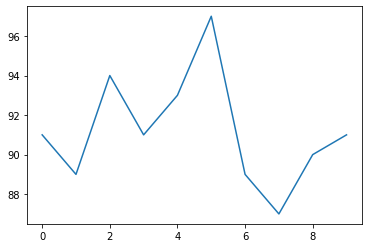

In [ ]:
print('mean of predictions:',np.mean(preds))
pd.Series(preds).plot()
pass

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
def report_results(model, y_true, y_predicted):
    y_predicted = np.argmax(y_predicted, axis=1)
    labels = (train.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    y_predicted = np.array([labels[k] for k in y_predicted])
    print(f"Accuracy score: {accuracy_score(y_true, y_predicted)}")
    print(classification_report(y_true, y_predicted))
    mat = confusion_matrix(y_true, y_predicted)
    sns.heatmap(mat, annot=True, cmap='mako')

    classes=labels.values()
    length = len(classes)
    plt.xticks(np.arange(length)+.5, classes, rotation= 90)
    plt.yticks(np.arange(length)+.5, classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

Accuracy score: 0.71
              precision    recall  f1-score   support

          Ak       0.00      0.00      0.00        18
   Ala_Idris       1.00      0.72      0.84        25
     Buzgulu       0.78      0.86      0.82        21
      Dimnit       0.40      1.00      0.57        16
       Nazli       1.00      0.95      0.97        20

    accuracy                           0.71       100
   macro avg       0.64      0.71      0.64       100
weighted avg       0.68      0.71      0.67       100



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


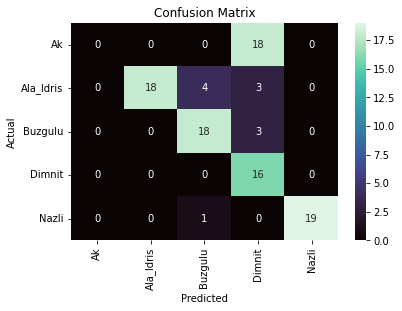

In [ ]:
report_results(model_ENB3, y_test, model_ENB3.predict(test))